# A Guide to Time Series Forecasting with Prophet in Python 3

* Ref: [https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3)
* Data: AirPassengers.csv

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display

## 1. Load data

In [15]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


* `Month` 是 string 型態，要轉換成 datetime64 然後把 `Month` 設為 index

In [18]:
# df['Month'] = pd.DatetimeIndex(df['Month']) # 也可以使用這個
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


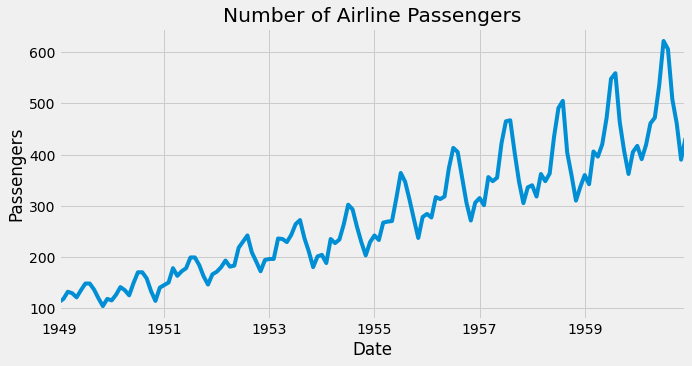

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
df['#Passengers'].plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.set_title('Number of Airline Passengers')
plt.show()

## 2. Analysis

## 3. Forecast

* Prophet 要求時間欄位的名字叫做 `ds` 變數欄位的名字叫做 `y` 而且時間欄位不是 index 而是普通的欄位
* Prophet 預測是利用 Markov chain Monte Carlo (MCMC) methods

In [21]:
# 把 dataframe 改成 Prophet 吃的格式
df.reset_index(inplace=True)
df.rename(columns={'Month': 'ds', '#Passengers': 'y'}, inplace=True)
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [22]:
from fbprophet import Prophet

# set the uncertainty interval to 95% (the Prophet default is 80%)
# 可以加上 daily_seasonality=True 和 weekly_seasonality=True 來看 daily 和 weekly 的 trend
model = Prophet(interval_width=0.95)
model.fit(df)

# Prophet 要做預測時，要餵入一個要預測的未來日期的 dataframe，這可以用 make_future_dataframe 來產生
df_future = model.make_future_dataframe(periods=36, freq='MS') # 預計未來 36 個月的, MS 表示每月的第一天
display(df_future.tail()) # df_future 包含了 df 的日期，並且又再多出了 36 個 time steps

print(len(df), len(df_future), len(df_future) - len(df))

# 做預測，傳回的結果也是一個 dataframe
df_forecast = model.predict(df_future)
display(df_forecast.head())

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
175,1963-08-01
176,1963-09-01
177,1963-10-01
178,1963-11-01
179,1963-12-01


144 180 36


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,107.146447,44.240361,131.421532,107.146447,107.146447,-21.478579,-21.478579,-21.478579,-21.478579,-21.478579,-21.478579,0.0,0.0,0.0,85.667868
1,1949-02-01,109.300675,33.360150,124.963685,109.300675,109.300675,-30.124122,-30.124122,-30.124122,-30.124122,-30.124122,-30.124122,0.0,0.0,0.0,79.176553
2,1949-03-01,111.246429,63.880918,153.441710,111.246429,111.246429,-0.407098,-0.407098,-0.407098,-0.407098,-0.407098,-0.407098,0.0,0.0,0.0,110.839332
3,1949-04-01,113.400657,60.513629,147.716757,113.400657,113.400657,-4.928447,-4.928447,-4.928447,-4.928447,-4.928447,-4.928447,0.0,0.0,0.0,108.472210
4,1949-05-01,115.485393,67.389830,158.058288,115.485393,115.485393,-3.631263,-3.631263,-3.631263,-3.631263,-3.631263,-3.631263,0.0,0.0,0.0,111.854130


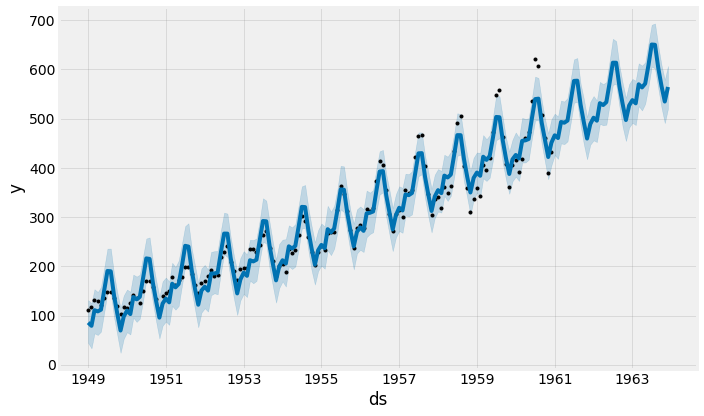

In [23]:
# visualization
# 要有 fig = 不然的話會畫出兩張圖
fig = model.plot(df_forecast, uncertainty=True)

* 黑點是 data 藍色的線是預測的結果，沒有分 train 和 test samples 而是把整個 time series 都拿去做預測 (包括未來的部分)

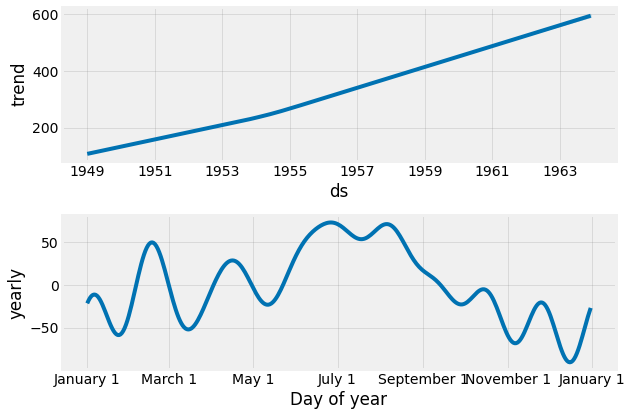

In [24]:
# visualization 看 daily, weekly and yearly patterns 的 trend
# 因為輸入是 monthly 的，所以實際上只會有 yearly pattern
# 要有 fig = 不然的話會畫出兩張圖
fig = model.plot_components(df_forecast)